# **Projeto Final**

Matéria: GPU28EE

Autor: Larissa Wierzynski Kulik


> ***Resumo:*** A ideia desse projeto é usar a GPU para processar imagens coloridas, aplicando o filtro gaussiano e posteriormente o metodo de convolução. Para o desenvolvimento será usado duas bibliotecas diferentes Numba e Cupy, que irão me auxiliar a programar em CUDA usando Python.

# Usando Numba

### Carrega as bibliotecas

In [2]:
from numba import cuda
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from math import exp

### Verifica o máximo de threads por bloco

In [3]:
device = cuda.get_current_device()
print("Máximo de threads por bloco:", device.MAX_THREADS_PER_BLOCK)

Máximo de threads por bloco: 1024


### Cria um Kernel para filtro Gaussiano

In [14]:
@cuda.jit
def gaussian_kernel(sigma, kernel_size, kernel):
    m = kernel_size // 2
    n = kernel_size // 2

    # Pega as coordenadas do thread dentro do bloco
    x = cuda.threadIdx.x
    y = cuda.threadIdx.y

    if x < kernel_size and y < kernel_size:
        kernel[y, x] = exp(-((x - m) ** 2 + (y - n) ** 2) / (2 * sigma ** 2))

### Cria um Kernel para convolução

In [15]:
@cuda.jit
def convolve(result, mask, image):
    i, j = cuda.grid(2)
    image_rows, image_cols = image.shape

    if i >= image_rows or j >= image_cols:
        return

    delta_row = mask.shape[0] // 2
    delta_col = mask.shape[1] // 2
    s = 0

    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + delta_row
            j_l = j - l + delta_col
            if (i_k >= 0 and i_k < image_rows) and (j_l >= 0 and j_l < image_cols):
                s += image[i_k, j_l] * mask[k, l]

    result[i, j] = s

### Carrega a imagem

In [16]:
image = np.asarray(Image.open('https://github.com/larikulik/Final-Project-GPU/blob/main/images.jpg'), dtype=np.float32) / 255.0  # Normaliza para [0,1]

In [ ]:
# Separar por (R, G, B)
image_r = image[:, :, 0]
image_g = image[:, :, 1]
image_b = image[:, :, 2]

### Configura as variaveis de suavização do filtro

In [17]:
sigma = 2.0
kernel_size = 15

### Copia o array para a memoria da GPU

In [18]:
d_kernel = cuda.device_array((kernel_size, kernel_size), dtype=np.float32)

### Define grid e blocos

In [19]:
blockdim = (32, 32)
griddim = (kernel_size // blockdim[0] + 1, kernel_size // blockdim[1] + 1)

### Aplica filtro Gaussiano na GPU

In [20]:
gaussian_kernel[griddim, blockdim](sigma, kernel_size, d_kernel)

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


LinkerError: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.5; current version is '8.4'

### Cria arrays na GPU

In [ ]:
d_image_r = cuda.to_device(image_r)
d_image_g = cuda.to_device(image_g)
d_image_b = cuda.to_device(image_b)

In [ ]:
d_result_r = cuda.device_array_like(image_r)
d_result_g = cuda.device_array_like(image_g)
d_result_b = cuda.device_array_like(image_b)

### Configurar tamanho dos blocos e grids para a convolução

In [ ]:
blockdim_convolve = (32, 32)
griddim_convolve = ((image.shape[0] + blockdim_convolve[0] - 1) // blockdim_convolve[0],
                    (image.shape[1] + blockdim_convolve[1] - 1) // blockdim_convolve[1])

### Aplicar convolução para cada cor (paralelismo?)

In [ ]:
convolve[griddim_convolve, blockdim_convolve](d_result_r, d_kernel, d_image_r)
convolve[griddim_convolve, blockdim_convolve](d_result_g, d_kernel, d_image_g)
convolve[griddim_convolve, blockdim_convolve](d_result_b, d_kernel, d_image_b)
cuda.synchronize()

### Transfere dados da GPU para CPU

In [ ]:
result_r = d_result_r.copy_to_host()
result_g = d_result_g.copy_to_host()
result_b = d_result_b.copy_to_host()

# Recombinar os canais processados
result_image = np.stack((result_r, result_g, result_b), axis=2)

# Converter de volta para intervalo [0,255]
result_image = (result_image * 255).astype(np.uint8)

### Plota resultados

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow((image * 255).astype(np.uint8))
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title('Imagem Filtrada')

plt.show()

# Usando Cupy

### Importando as Bibliotecas

In [10]:
import cupy as cp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Criando o filtro gaussiano
---
Para isso é utilizado o `cp.ElementwiseKernel`, com ele é possivel rodar uma função na GPU. Diferente do cuda.jit ele gerencia os grids e blocos automaticamente.

*Exemplo:*

```
kernel = cp.ElementwiseKernel(
    'int32 x, int32 y', # Variáveis de entrada
    'int32 z',          # Variável de saída
    'z = x + y',        # Operação que será realizada
    'soma'              # Nome do kernel
)
```




In [16]:
gaussian_kernel = cp.ElementwiseKernel( # usado para rodar a função na GPU
    'float32 sigma, int32 kernel_size, int32 x, int32 y', # entrada
    'float32 kernel', #saida
    '''
    int m = kernel_size / 2;
    int n = kernel_size / 2;
    kernel = exp(-((x - m) * (x - m) + (y - n) * (y - n)) / (2 * sigma * sigma));
    ''',
    'gaussian_kernel' # nome do kernel
)

### Criando o kernel de convolução

---

Para esse caso foi utilizado o ```cp.RawKernel```, que permite ter mais controle sobre a GPU, utilizando C++.

Esse método é parecido com o `@cuda.jit`, já que é necessario definir o tamanho dos grids e blocos do kernel, essa função é mais utilizada para metodos de convolução.

Para esse caso foi usado um:

*   bloco de (32,32);
*   grid_size de `(image.shape[0] // block_size[0] + 1, image.shape[1] // block_size[1] + 1)` .

garantido que cada pixel seja processado.



In [30]:
conv_kernel = cp.RawKernel(r'''
extern "C" __global__
void convolve(const float *image, const float *mask, float *result, int rows, int cols, int mask_size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < rows && j < cols) {
        int half_size = mask_size / 2;
        float sum = 0.0;

        for (int k = 0; k < mask_size; k++) {
            for (int l = 0; l < mask_size; l++) {
                int i_k = i - half_size + k;
                int j_l = j - half_size + l;

                if (i_k >= 0 && i_k < rows && j_l >= 0 && j_l < cols) {
                    sum += image[i_k * cols + j_l] * mask[k * mask_size + l];
                }
            }
        }
        result[i * cols + j] = sum;
    }
}
''', 'convolve')

### Parametros para alterar a suavização/borrão da imagem


---

Quanto maior o sigma e o kernel_size, mais a imagem vai desfocar

In [13]:
sigma = 10.0
kernel_size = 30

### Aplica filtro gaussiano na GPU

In [17]:
x, y = cp.meshgrid(cp.arange(kernel_size, dtype=cp.int32), cp.arange(kernel_size, dtype=cp.int32))
kernel = gaussian_kernel(sigma, kernel_size, x, y)
kernel /= cp.sum(kernel)  # Normalização

### Carrega a imagem

In [19]:
image = np.asarray(Image.open('https://github.com/larikulik/Final-Project-GPU/blob/main/images.jpg'))  # carrega a imagem em um numpy array
image = cp.asarray(image, dtype=cp.float32)  # copia a imagem para a gpu

### Separação por cor R, G, B

In [20]:
image_r = image[:, :, 0]
image_g = image[:, :, 1]
image_b = image[:, :, 2]

In [21]:
# cria os arrays de resultado, baseados nos anteriores
result_r = cp.zeros_like(image_r)
result_g = cp.zeros_like(image_g)
result_b = cp.zeros_like(image_b)

### Configura o tamanho do bloco e do grid

---

Como a GPU que roda com, no máximo, 1024 threads por bloco.

É possivel definir o block_size como 32,32 já que 32x32=1024.

In [22]:
block_size = (32, 32)
grid_size = (image.shape[0] // block_size[0] + 1, image.shape[1] // block_size[1] + 1)

### Aplicar convolução para cada array de cor

In [27]:
conv_kernel(grid_size, block_size, (image_r.ravel(), kernel.ravel(), result_r.ravel(), image.shape[0], image.shape[1], kernel_size))
conv_kernel(grid_size, block_size, (image_g.ravel(), kernel.ravel(), result_g.ravel(), image.shape[0], image.shape[1], kernel_size))
conv_kernel(grid_size, block_size, (image_b.ravel(), kernel.ravel(), result_b.ravel(), image.shape[0], image.shape[1], kernel_size))


In [28]:
# usa a função stack para juntar os arrays de cores e retornar a imagem original
result_image = cp.stack((result_r, result_g, result_b), axis=2)

# tranfere os dados novamente para a cpu
result_host = result_image.get().astype(np.uint8)

### Plotar o resultado

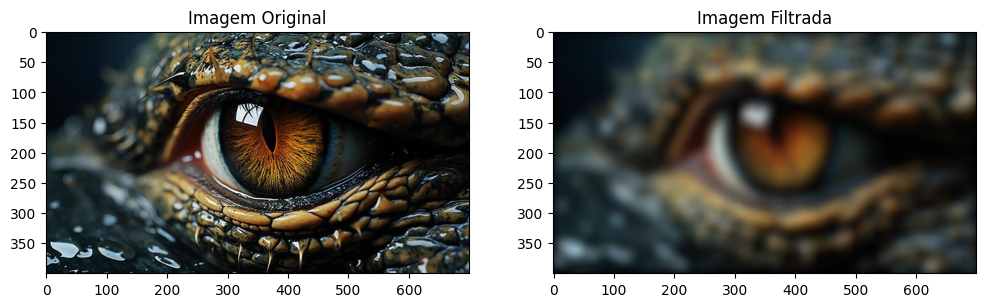

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.get().astype(np.uint8))
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(result_host)
plt.title('Imagem Filtrada')

plt.show()
